# Projet 3 - Moteur de Recommandations de films
# Nettoyage des Données
# Partie Exploratoire

## Import des Librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from mes_fonctions import *

## Import du fichier

In [3]:
datas_raw = pd.read_csv('movie_metadata.csv')

## Premieres Infos

### Synthèse Infos
1. Les colonnes initiales
       'color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'
       
2. Descriptions des colonnes

    - color : color / Black & White -> ['Color', nan, ' Black and White']
    - movie_title : titre du film
    - country : pays de diffusion / exploitation ???
    - language : langue du film
    - title_year : année du film -> 1916 / 2016
    - budget : budget du film
    - gross : recette brute
    - aspect_ratio : aspect de diffusion du film -> 23 diff 
    - imdb_score : note imdb -> 1.6 / 9.5
    - movie_imdb_link : lien imdb
    - genres : genre du film séparé par des |
    - num_critic_for_reviews : nombre de critique en commentaires
    - num_user_for_reviews : nb d'utilisers à commenter
    - num_voted_users : nb de votant du film
    - content_rating : label / interdiction ages -> 
    ['PG-13', nan, 'PG', 'G', 'R', 'TV-14', 'TV-PG', 'TV-MA', 'TV-G',
       'Not Rated', 'Unrated', 'Approved', 'TV-Y', 'NC-17', 'X', 'TV-Y7',
       'GP', 'Passed', 'M']
    - plot_keywords : mots clefs du film
    - duration : durée du film en minutes -> valeur min ok 7 / 511 valeur max (série) 
    - facenumber_in_poster : nb de personnages sur l'affiche -> 0 / 31 : semble ok
    - movie_facebook_likes : nb de like du film -> commence à 0 (attention à cette valeur) / max : 349000 Interstellar (ok)

    - director_name : Nom 
    - director_facebook_likes : nb de like facebook du director

    - actor_1_name : nom acteur1
    - actor_1_facebook_likes : nb like actor1

    - actor_2_name : nom acteur2
    - actor_2_facebook_likes : nb like actor2

    - actor_3_name : nom acteur3
    - actor_3_facebook_likes : nb like actor3

    - cast_total_facebook_likes : nb de like total des acteurs
    

# Création des Identifiant des Films

In [4]:
import re
def get_id(value):
    m = re.search('(?<=tt)[0-9]*$', value.split('/')[4])
    return int(m.group(0))

datas_raw['id'] = datas_raw['movie_imdb_link'].apply(get_id)

## On va réordonner les colonnes pour une question de lisibilité
> en regroupant les infos proches

In [5]:
l_columns = ['id', 
 'movie_title',
 'title_year',
 'imdb_score',
 'content_rating',
 'duration',
 'aspect_ratio',
 'color',
 'movie_imdb_link',
 'budget',
 'gross',
 'language',
 'country',
 'facenumber_in_poster',
 'genres',
 'plot_keywords',
 'num_critic_for_reviews',
 'num_voted_users',
 'num_user_for_reviews',
 'director_name',
 'director_facebook_likes',
 'actor_1_name',
 'actor_1_facebook_likes',
 'actor_2_name',
 'actor_2_facebook_likes',
 'actor_3_name',
 'actor_3_facebook_likes',
 'movie_facebook_likes',
 'cast_total_facebook_likes']

In [6]:
datas_raw = datas_raw[l_columns]

## Doublons sur les ID

> Il y a une différence sur le nom d'un acteur3, sinon les différences pour ces valeurs se situent au niveau des nombres (de likes / votes ou commentaires ) 
>
> Considérons que moins de 1% de différence et nous prenons la donnée qui semble la plus récente (le max)


In [7]:
def analyse_diff_values_by_serie(m_serie, taux_diff_max=0.01):
    '''Fonction qui renvoie le max si la différence min-max 
    est inférieure au taux fixé (par défaut 1%)
    INPUT: 
        - m_serie : la série à traiter
        - taux_diff_max (optionnel : par défaut 0.01) le taux maximum accepté
    OUTPUT:
        - True / False : état de l'analyse -- si la différence est inférieur au taux max
        - valeur maximum : valeur maximum de la série
        - message_error
    '''
    mmin = m_serie.min()
    mmax = m_serie.max()
    if mmax==0:
        return (False,0, 'mmax == 0')
    taux_diff = 1 - mmin/mmax
    if (taux_diff<taux_diff_max):
        return (True, mmax,'')
    else:
        error_msg = 'Nous avons ici mmin = {mmin} -- mmax = {mmax}'.format(mmin=mmin, mmax=mmax)
        return (False, mmin, error_msg)

In [8]:
def set_value_for_id_and_col(m_dataframe, col_name, m_id, value):
    '''Fonction qui modifie le dataframe en mettant la valeur 'value' 
    dans le colonne 'col_name' pour l'id 'm_id' 
    '''
    m_dataframe_idx = m_dataframe[m_dataframe['id']==m_id].index
    m_dataframe.loc[m_dataframe_idx, col_name] = value

## On supprime les doublons qui n'ont aucune différence dans les colonnes

In [9]:
def suppress_doublon_id(m_dataframe, id):
    '''Fonction qui supprime les doublons de lignes ayant le même id
    INPUT: 
        - m_dataframe 
        - id
    INFORMATION:
        On supprime les lignes autres que la 1e 
    '''
    idx = m_dataframe[m_dataframe['id']==id].index
    idx_min = idx.min()

    for idxx in idx:
        if (idxx!=idx_min):
            ###print("ID {ID} -> on supprime la ligne d'index {idx}".format(ID=id, idx=idxx))
            m_dataframe.drop(index=idxx,axis=0,inplace=True)

In [10]:
def traite_difference_une_colonne_by_id(m_dataframe, id, col_name, taux_diff_max):
        # S'il ne reste pas de doute sur les données restante
        #   on renvoie True sinon False (pour ne pas supprimer la donnée)
        m_serie = m_dataframe[m_dataframe['id']==id][col_name]
        
        # Nombre de valeurs différentes
        n_diff = m_serie.nunique()
        
        if n_diff>0:
            # Si on des valeurs nulles et d'autres non nulle 
            if n_diff==1:
                # On a une seule valeur (quantitative ou qualitative)
                # -> On remplace les valeurs nulle par celle non nulle
                value = m_serie[m_serie.notnull()].unique()[0]
                set_value_for_id_and_col(m_dataframe, col_name, id, value )
                return True
            else:
                # On a plusieurs valeurs : 
                # Si on est dans les colonnes quantitatives :
                #   - on va modifier si diff min/max est inférieur au taux
                if col_name in ['actor_1_facebook_likes', 'cast_total_facebook_likes', 
                                'num_voted_users', 'actor_3_facebook_likes', 
                                'actor_2_facebook_likes', 'num_user_for_reviews']:
                    etat, value, msg = analyse_diff_values_by_serie(m_serie, taux_diff_max)
                    if etat==False:
                        # S'il y a une différence supérieur au taux fixé on ne fait rien mais on affiche
                        #print('--------\n-- ERREUR sur {id} -- col : {col} -- {msg}\n--------'\
                        #      .format(id=id, col=col_name, msg=msg))
                        print('-- ERREUR sur {id} -- col : {col} -- {msg}'\
                              .format(id=id, col=col_name, msg=msg))
                        return False
                    else:
                        # Sinon on utilise la plus grande des valeurs pour toutes les lignes
                        set_value_for_id_and_col(m_dataframe, col_name, id, value )
                        return True
                else:
                    # On a plusieurs valeur qualitative : on ne peut rien faire
                    print('\t-> Difference ID : {ID} - Colonne {col}'.format(ID=id, col=col_name))
                    return False
        else:
            # Toutes les valeurs sont vides on peut supprimer les doublons
            return True

In [11]:
def traite_doublons_id(m_dataframe, taux_diff_max=0.01):
    # On identifie les id en doublons
    u = m_dataframe.groupby(['id']).size().reset_index(name='Freq')
    print("DEBUT : Nous avons {} id différents avec des doublons ".format(sum(u['Freq']>1)))
    
    # On va devoir analyser où se trouve la différence entre les lignes pour toutes ces données
    m_dataframe_doublon = u[u['Freq']>1]

    
                        
    # On parcourt l'ensemble des id en doublons
    for id in m_dataframe_doublon['id'].values:
        # on fabrique un dataframe temporaire
        m_df_tmp = m_dataframe[m_dataframe['id']==id]
        id_supprimable = True 
        
        for col in m_df_tmp.columns:
            # On parcourt toutes les colonnes pour cet id
            b_res = traite_difference_une_colonne_by_id(m_dataframe=m_dataframe, 
                                                  id=id, 
                                                  col_name=col, 
                                                  taux_diff_max=taux_diff_max)
            id_supprimable = id_supprimable & b_res

        # Si aucune colonne ne pose problème 
        # -> on supprime les doublons de cet id
        if (id_supprimable):
            # Toutes les colonnes sont identiques : 
            # -> on supprime une des lignes de cet id
            suppress_doublon_id(m_dataframe, id)
    
    u = m_dataframe.groupby(['id']).size().reset_index(name='Freq')
    print("FIN : Il reste {} id différents avec des doublons ".format(sum(u['Freq']>1)))

In [12]:
traite_doublons_id(datas_raw, taux_diff_max=0.01)

DEBUT : Nous avons 117 id différents avec des doublons 
-- ERREUR sur 360139 -- col : cast_total_facebook_likes -- Nous avons ici mmin = 829 -- mmax = 842
	-> Difference ID : 765010 - Colonne actor_3_name
-- ERREUR sur 765010 -- col : actor_3_facebook_likes -- Nous avons ici mmin = 1000.0 -- mmax = 3000.0
-- ERREUR sur 765010 -- col : cast_total_facebook_likes -- Nous avons ici mmin = 39473 -- mmax = 42473
-- ERREUR sur 1343092 -- col : actor_3_facebook_likes -- Nous avons ici mmin = 76.0 -- mmax = 77.0
	-> Difference ID : 2638144 - Colonne imdb_score
-- ERREUR sur 2638144 -- col : num_voted_users -- Nous avons ici mmin = 57 -- mmax = 67
-- ERREUR sur 3332064 -- col : actor_2_facebook_likes -- Nous avons ici mmin = 548.0 -- mmax = 559.0
FIN : Il reste 5 id différents avec des doublons 


> Nous voyons qu'il y a des différences sur des valeurs
> quantitatives un peu plus importantes que 1% mais en dessous de 20%
> 
> Elles sont en nombre restreint : nous allons les modifier

In [13]:
traite_doublons_id(datas_raw, taux_diff_max=0.2)

DEBUT : Nous avons 5 id différents avec des doublons 
	-> Difference ID : 765010 - Colonne actor_3_name
-- ERREUR sur 765010 -- col : actor_3_facebook_likes -- Nous avons ici mmin = 1000.0 -- mmax = 3000.0
	-> Difference ID : 2638144 - Colonne imdb_score
FIN : Il reste 2 id différents avec des doublons 


> Nous avons une donnée qui pose souci : id = 2638144
> 
> Avec une différences sur : imdb_score

In [14]:
datas_raw[datas_raw['id']==2638144][['movie_title', 'imdb_score', 'title_year']].T

,367,2613,3967
movie_title,Ben-Hur,Ben-Hur,Ben-Hur
imdb_score,6.1,6.1,6
title_year,2016,2016,2016


In [15]:
# Nous allons uniquement garder la valeur qui est en double soit 6.1
# C'est le cas : On supprime manuellement les indexes 367 et 3967
datas_raw.drop(index=367,axis=0,inplace=True)
datas_raw.drop(index=3967,axis=0,inplace=True)

> Analyse de l'autre données en double: id = 765010
>
> Nous avons les données : 'actor_3_name', 'actor_3_facebook_likes' différentes

In [16]:
datas_raw[datas_raw['id']==765010][['movie_title', 'actor_3_name', 'actor_3_facebook_likes']].T

,1852,2882
movie_title,Brothers,Brothers
actor_3_name,Bailee Madison,Ethan Suplee
actor_3_facebook_likes,3000,1000


In [17]:
# l'acteur3 a été changé
# on va supprimer la ligne ayant l'acteur qui a le moins de like entre les 2
datas_raw.drop(index=2882,axis=0,inplace=True)

In [18]:
# Encore une vérification mais nous ne devons plus avoir de doublons d'id
traite_doublons_id(datas_raw, taux_diff_max=0.01)

DEBUT : Nous avons 0 id différents avec des doublons 
FIN : Il reste 0 id différents avec des doublons 


# Gestion des personnes
> On fabrique un dataframe avec les noms des personnes (acteurs et réalisateurs)

In [19]:
def fabrication_personns():
    df1 = datas_raw[['actor_1_name','actor_1_facebook_likes']]
    df2 = datas_raw[['actor_2_name','actor_2_facebook_likes']]
    df3 = datas_raw[['actor_3_name','actor_3_facebook_likes']]
    df4 = datas_raw[['director_name','director_facebook_likes']]

    df1.columns = ['nom','facebook_likes']
    df2.columns = ['nom','facebook_likes']
    df3.columns = ['nom','facebook_likes']
    df4.columns = ['nom','facebook_likes']

    personns = pd.concat([df1, df2, df3, df4],keys=['actor_1', 'actor_2', 'actor_3', 'director'])
    return personns

In [20]:
personns = fabrication_personns()

# Verification des nombres de likes différents

In [21]:
def set_value_for_nom_and_col(m_dataframe, col_name, m_nom, value):
    '''Fonction qui modifie le dataframe en mettant la valeur 'value' 
    dans le colonne 'col_name' pour l'id 'm_id' 
    '''
    m_dataframe_idx = m_dataframe[m_dataframe['nom']==m_nom].index
    m_dataframe.loc[m_dataframe_idx, col_name] = value

In [22]:
def traite_difference_une_colonne_by_nom(m_dataframe, nom, col_name, taux_diff_max):
        # S'il ne reste pas de doute sur les données restante
        #   on renvoie True sinon False (pour ne pas supprimer la donnée)
        m_serie = m_dataframe[m_dataframe['nom']==nom][col_name]
        
        # Nombre de valeurs différentes
        n_diff = m_serie.nunique()
        
        if n_diff>0:
            # Si on des valeurs nulles et d'autres non nulle 
            if n_diff==1:
                # On a une seule valeur (quantitative ou qualitative)
                # -> On remplace les valeurs nulle par celle non nulle
                value = m_serie[m_serie.notnull()].unique()[0]
                set_value_for_nom_and_col(m_dataframe, col_name, nom, value )
                return True
            else:
                # On a plusieurs valeurs : 
                # Si on est dans les colonnes quantitatives :
                #   - on va modifier si diff min/max est inférieur au taux
                if col_name in ['facebook_likes']:
                    etat, value, msg = analyse_diff_values_by_serie(m_serie, taux_diff_max)
                    if etat==False:
                        # S'il y a une différence supérieur au taux fixé on ne fait rien mais on affiche
                        #print('--------\n-- ERREUR sur {id} -- col : {col} -- {msg}\n--------'\
                        #      .format(id=id, col=col_name, msg=msg))
                        print('-- ERREUR sur {nom} -- col : {col} -- {msg}'\
                              .format(nom=nom, col=col_name, msg=msg))
                        return False
                    else:
                        # Sinon on utilise la plus grande des valeurs pour toutes les lignes
                        set_value_for_nom_and_col(m_dataframe, col_name, nom, value )
                        return True
                else:
                    # On a plusieurs valeur qualitative : on ne peut rien faire
                    print('\t-> Difference ID : {ID} - Colonne {col}'.format(ID=id, col=col_name))
                    return False
        else:
            # Toutes les valeurs sont vides on peut supprimer les doublons
            return True

In [23]:
def traite_doublons_nom(m_dataframe, taux_diff_max=0.01):
    # On identifie les id en doublons
    u = m_dataframe.groupby(['nom','facebook_likes']).size().reset_index(name='Freq')
    u = u.groupby(['nom']).size().reset_index(name='Freq2')
    print("DEBUT : Nous avons {} id différents avec des doublons ".format(sum(u['Freq2']>1)))


    # On va devoir analyser où se trouve la différence entre les lignes pour toutes ces données
    m_dataframe_doublon = u[u['Freq2']>1]
                        
    # On parcourt l'ensemble des id en doublons
    for nom in m_dataframe_doublon['nom'].values:
        # on fabrique un dataframe temporaire
        m_df_tmp = m_dataframe[m_dataframe['nom']==nom]
        id_supprimable = True 
        
        for col in m_df_tmp.columns:
            # On parcourt toutes les colonnes pour cet id
            b_res = traite_difference_une_colonne_by_nom(m_dataframe=m_dataframe, 
                                                  nom=nom, 
                                                  col_name=col, 
                                                  taux_diff_max=taux_diff_max)
            id_supprimable = id_supprimable & b_res
    
    u = m_dataframe.groupby(['nom','facebook_likes']).size().reset_index(name='Freq')
    u = u.groupby(['nom']).size().reset_index(name='Freq2')
    print("FIN : Il reste {} id différents avec des doublons ".format(sum(u['Freq2']>1)))

In [24]:
traite_doublons_nom(personns, taux_diff_max=0.01)

DEBUT : Nous avons 128 id différents avec des doublons 
-- ERREUR sur Alan Taylor -- col : facebook_likes -- Nous avons ici mmin = 12.0 -- mmax = 230.0
-- ERREUR sur Anne Heche -- col : facebook_likes -- Nous avons ici mmin = 643.0 -- mmax = 695.0
-- ERREUR sur Bruce Campbell -- col : facebook_likes -- Nous avons ici mmin = 0.0 -- mmax = 298.0
-- ERREUR sur Bruce Greenwood -- col : facebook_likes -- Nous avons ici mmin = 981.0 -- mmax = 991.0
-- ERREUR sur Dana Ivey -- col : facebook_likes -- Nous avons ici mmin = 268.0 -- mmax = 271.0
-- ERREUR sur Dyan Cannon -- col : facebook_likes -- Nous avons ici mmin = 257.0 -- mmax = 267.0
-- ERREUR sur George Miller -- col : facebook_likes -- Nous avons ici mmin = 18.0 -- mmax = 750.0
-- ERREUR sur Josie Ho -- col : facebook_likes -- Nous avons ici mmin = 76.0 -- mmax = 77.0
-- ERREUR sur Michael Chapman -- col : facebook_likes -- Nous avons ici mmin = 70.0 -- mmax = 366.0
-- ERREUR sur Nick Gomez -- col : facebook_likes -- Nous avons ici mmin

> On voit que pour plusieurs noms il n'y a que peu de doute sur le nombre facebook qui a évolué
>
> Même si le pourcentage d'augmentation est plus que 1% (mais moins que 20%)

In [25]:
traite_doublons_nom(personns, taux_diff_max=0.2)

DEBUT : Nous avons 12 id différents avec des doublons 
-- ERREUR sur Alan Taylor -- col : facebook_likes -- Nous avons ici mmin = 12.0 -- mmax = 230.0
-- ERREUR sur Bruce Campbell -- col : facebook_likes -- Nous avons ici mmin = 0.0 -- mmax = 298.0
-- ERREUR sur George Miller -- col : facebook_likes -- Nous avons ici mmin = 18.0 -- mmax = 750.0
-- ERREUR sur Michael Chapman -- col : facebook_likes -- Nous avons ici mmin = 70.0 -- mmax = 366.0
-- ERREUR sur Nick Gomez -- col : facebook_likes -- Nous avons ici mmin = 22.0 -- mmax = 347.0
-- ERREUR sur Steve James -- col : facebook_likes -- Nous avons ici mmin = 23.0 -- mmax = 96.0
FIN : Il reste 6 id différents avec des doublons 


In [26]:
l_noms = ['Alan Taylor', 'Bruce Campbell', 'George Miller', 'Michael Chapman', 'Nick Gomez', 'Steve James']
for i_nom in l_noms:
    print(personns[personns['nom']==i_nom])

                       nom  facebook_likes
actor_2  3923  Alan Taylor            12.0
director 109   Alan Taylor           230.0
         127   Alan Taylor           230.0
                          nom  facebook_likes
actor_3  1187  Bruce Campbell           298.0
director 4429  Bruce Campbell             0.0
                         nom  facebook_likes
director 128   George Miller           750.0
         175   George Miller           750.0
         397   George Miller           750.0
         500   George Miller           750.0
         3110  George Miller           750.0
         3722  George Miller            18.0
         4254  George Miller           750.0
         4895  George Miller           750.0
                           nom  facebook_likes
actor_2  4245  Michael Chapman           366.0
director 2729  Michael Chapman            70.0
                      nom  facebook_likes
actor_3  2281  Nick Gomez           347.0
director 2566  Nick Gomez            22.0
                  

> Pour ces 6 noms nous avons des doutes sur les potentiels homonymes
>
> Après une petite recherche sur Internet nous constatons que 
> - Alan Taylor
> - George Miller
> - Michael Chapman
> - Steve James
> 
> sont les noms d'acteurs mais aussi de réalisateurs (mais pas les mêmes personnes) 
>
> Nous allons ajouter des mots pour les différencier
> en modifiant manuellement


In [27]:
datas_raw.loc[3923,'actor_2_name'] = 'Alan Taylor (actor)'
datas_raw.loc[4429,'director_facebook_likes'] = 298.0
datas_raw.loc[3722,'director_name'] = 'George Miller (director1)'
datas_raw.loc[2729,'director_name'] = 'Michael Chapman (director)'
datas_raw.loc[2566,'director_facebook_likes'] = 347.0
datas_raw.loc[4817,'actor_2_name'] = 'Steve James (actor)'

> Maintenant que nous avons différencié les homonymes 
> nous pouvons recommencer le travail et uniformiser les
> nombre de like de chaque personne

In [28]:
personns = fabrication_personns()
traite_doublons_nom(personns, taux_diff_max=0.2)

DEBUT : Nous avons 122 id différents avec des doublons 
FIN : Il reste 0 id différents avec des doublons 


> Il reste à mettre à jour le dataframe originel

In [29]:
p1 = personns.loc['actor_1']
datas_raw.loc[p1.index, 'actor_1_facebook_likes'] = p1['facebook_likes']

p2 = personns.loc['actor_2']
datas_raw.loc[p2.index, 'actor_2_facebook_likes'] = p2['facebook_likes']

p3 = personns.loc['actor_3']
datas_raw.loc[p3.index, 'actor_3_facebook_likes'] = p3['facebook_likes']

p4 = personns.loc['director']
datas_raw.loc[p4.index, 'director_facebook_likes'] = p4['facebook_likes']

In [30]:
# Une vérification pour la forme 
personns = fabrication_personns()
traite_doublons_nom(personns, taux_diff_max=0.001)

DEBUT : Nous avons 0 id différents avec des doublons 
FIN : Il reste 0 id différents avec des doublons 


# Verifications sur les prenoms mal écrits
## On vérifie s'il n'y a pas des erreurs d'écriture des noms
> Cela s'avère une fausse piste

In [31]:
personns[:4]

nom  facebook_likes
actor_1 0      CCH Pounder          1000.0
        1      Johnny Depp         40000.0
        2  Christoph Waltz         11000.0
        3        Tom Hardy         27000.0

In [32]:
def get_name_shortName(complete_name):
    if type(complete_name)==float:
        return (np.nan, np.nan)
    
    name_l = complete_name.split(' ')
    short_name = name_l[0]
    name_l.remove(short_name)
    name = ' '.join(name_l)
    
    if name=='':
        name = short_name
        short_name = ''
        
    return (name, short_name)
    

In [33]:
personns['nom_f'] = personns['nom'].apply(lambda x: get_name_shortName(x)[0])
personns['prenom'] = personns['nom'].apply(lambda x: get_name_shortName(x)[1])

In [34]:
u2 = personns.groupby(['nom_f', 'prenom']).agg(len).groupby(['nom_f']).agg(len)

In [35]:
tmp = personns.groupby(['nom_f', 'prenom'])['nom_f', 'prenom'].agg(len).groupby(['nom_f']).agg(len)

In [36]:
tmp = personns.groupby(['nom_f', 'prenom'])['nom_f', 'prenom'].size()\
    .reset_index(name='Freq')\
    .groupby(['nom_f'])['nom_f'].size().reset_index(name='Freq2')

tmp = tmp[tmp['Freq2']>1]

In [37]:
tmp.values

array([['Aaron', 2],
       ['Abraham', 2],
       ['Ackles', 2],
       ...,
       ['Zito', 2],
       ['Zucker', 3],
       ['Zwick', 2]], dtype=object)

In [38]:
## La liste des potentielles erreur sur les prenom pour les noms est : 
dict_nom = {}
for i in tmp.values:
    u = personns[personns['nom_f']==i[0]]['prenom']
    nom_tmp = i[0]
    p_tmp = list(set(u.values))
    l_prenom = []
    for j in p_tmp:
        prenom_tmp = j
        for v in p_tmp:
            if v!=prenom_tmp:
                distance = sum([1 for x, y in zip(prenom_tmp, v) if x.lower() != y.lower()])
                if distance<2:
                    #print("Attention pour le nom ({}) - prénom1 ({}) - prénom2 ({})"\
                    #      .format(nom_tmp, prenom_tmp, v))
                    l_prenom.append(prenom_tmp)
        if (len(l_prenom)!=0):
            l_prenom = list(set(l_prenom))
            dict_nom[nom_tmp] = l_prenom
            

In [39]:
dict_nom

{'Adams': ['Claire', 'Jane', 'CJ', 'Jay'],
 'Anderson': ['Pamela', 'Sam'],
 'Atkins': ['Chris', 'Christopher'],
 'Aviles': ['Rick', 'Vic'],
 'Brooks': ['Mehcad', 'Mel'],
 'Brown': ['Brianna', 'Bryan', 'Rob', 'Bobby'],
 'Burke': ['Billy', 'Billie'],
 'Capra': ['Francis', 'Frank'],
 'Cassidy': ['Joanna', 'Joe'],
 'Chang': ['Chin-Chien', 'Chen'],
 'Clarke': ['Dameon', 'Cam'],
 'Cooper': ['Garry', 'Gary'],
 'Cox': ['Chris', 'Christina'],
 'Cross': ['Ben', 'Kendrick', 'Joseph', 'Joe'],
 'Davis': ['Ossie', 'Essie'],
 'Divine': ['', 'Colette'],
 'Drake': ['', 'Joyful', 'Larry'],
 'Ewing': ['Heidi', 'Reid'],
 'Fitzgerald': ['Tac', 'Tara'],
 'Foster': ['Jon', 'Jodie'],
 'Franklin': ['Al', 'Aretha'],
 'Gomez': ['Rick', 'Nick'],
 'Gordon': ['Dennie', 'Don'],
 'Hooper': ['Tobe', 'Tom'],
 'Howard': ['John', 'Joe'],
 'Hunter': ['Kim', 'Tim'],
 'Johnson': ['Kenneth', 'Ben'],
 'Jones': ['Duane', 'Dean'],
 'Lawrence': ['Marc', 'Martin'],
 'Lee': ['Sngmoo', 'Angelica', 'Ang'],
 'Lucas': ['Jon', 'John'],

> il va falloir passer à la main sur les doublons potentiels
>
> ex: Joe / John, Will / William, Saul / Paul, Oliver / Ol, Gary / Garry, Chris / Christopher

'Adams': ['CJ', 'Claire', 'Jay', 'Jane'],
 'Anderson': ['Pamela', 'Sam'],
 'Atkins': ['Chris', 'Christopher'],
 'Aviles': ['Rick', 'Vic'],
 'Brooks': ['Mehcad', 'Mel'],
 'Brown': ['Rob', 'Brianna', 'Bobby', 'Bryan'],
 'Burke': ['Billie', 'Billy'],
 'Capra': ['Frank', 'Francis'],
 'Cassidy': ['Joanna', 'Joe'],
 'Chang': ['Chin-Chien', 'Chen'],
 'Clarke': ['Cam', 'Dameon'],
 'Cooper': ['Gary', 'Garry'],
 'Cox': ['Chris', 'Christina'],
 'Cross': ['Ben', 'Kendrick', 'Joseph', 'Joe'],
 'Davis': ['Essie', 'Ossie'],
 'Divine': ['', 'Colette'],
 'Drake': ['', 'Joyful', 'Larry'],
 'Ewing': ['Heidi', 'Reid'],
 'Fitzgerald': ['Tara', 'Tac'],
 'Foster': ['Jon', 'Jodie'],
 'Franklin': ['Al', 'Aretha'],
 'Gomez': ['Rick', 'Nick'],
 'Gordon': ['Dennie', 'Don'],
 'Hooper': ['Tom', 'Tobe'],
 'Howard': ['John', 'Joe'],
 'Hunter': ['Tim', 'Kim'],
 'Johnson': ['Ben', 'Kenneth'],
 'Jones': ['Duane', 'Dean'],
 'Lawrence': ['Martin', 'Marc'],
 'Lee': ['Ang', 'Angelica', 'Sngmoo'],
 'Lucas': ['Jon', 'John'],
 'Marsh': ['Marian', 'Mae'],
 'Miller': ['Chris', 'Ben', 'Christa', 'Bennett'],
 'Moore': ['Michael', 'Rich'],
 'Morrow': ['Michele', 'Vic'],
 'Murray': ['Jillian', 'Bill'],
 'Norton': ['James', 'Jim'],
 'Parker': ['Alan',
  'Eleanor',
  'Trey',
  'Oliver',
  'Ol',
  'Ty',
  'Nate',
  'Nathaniel'],
 'Perez': ['Danny', 'Manny'],
 'Pink': ['', 'Steve'],
 'Puri': ['Om', 'Amrish'],
 'Reed': ['Dan', 'Donna'],
 'Remo': ['', 'Johnny'],
 'Rice': ['Tim', 'Simeon'],
 'Ryan': ['Max', 'Pat', 'Matt'],
 'Sheridan': ['Jamey', 'Jim'],
 'Simpson': ['John', 'Joe'],
 'Smith': ['Willow', 'Will', 'William'],
 'Taylor': ['Dendrie', 'Don'],
 'West': ['Simon', 'Timothy', 'Billy', 'Ti'],
 'Williams': ['Paul', 'Katt', 'Saul', 'Matt'],
 'Wright': ['Jon', 'Joe'],
 'Zhang': ['Li', 'Yimou']}

In [40]:
personns[(personns['nom_f']=='Smith') & ((personns['prenom']=='Will') | (personns['prenom']=='William'))]

nom  facebook_likes  nom_f   prenom
actor_1 19       Will Smith         10000.0  Smith     Will
        71       Will Smith         10000.0  Smith     Will
        73       Will Smith         10000.0  Smith     Will
        116      Will Smith         10000.0  Smith     Will
        117      Will Smith         10000.0  Smith     Will
        152      Will Smith         10000.0  Smith     Will
        190      Will Smith         10000.0  Smith     Will
        197      Will Smith         10000.0  Smith     Will
        272      Will Smith         10000.0  Smith     Will
        274      Will Smith         10000.0  Smith     Will
        352      Will Smith         10000.0  Smith     Will
        390   William Smith           919.0  Smith  William
        409      Will Smith         10000.0  Smith     Will
        522      Will Smith         10000.0  Smith     Will
        673      Will Smith         10000.0  Smith     Will
        842      Will Smith         10000.0  Smith     Will
        851      Will Smith         10000.0  Smith     Will
        893      Will Smith         10000.0  Smith     Will
        1468     Will Smith         10000.0  Smith     Will
        2052     Will Smith         10000.0  Smith     Will
        4712  William Smith           919.0  Smith  William
actor_2 787      Will Smith         10000.0  Smith     Will
        3128  William Smith           919.0  Smith  William
actor_3 676   William Smith           919.0  Smith  William

In [41]:
datas_raw.loc[[390,352,787]].T

,390,352,787
id,82198,119654,146984
movie_title,Conan the Barbarian,Men in Black,The Legend of Bagger Vance
title_year,1982,1997,2000
imdb_score,6.9,7.3,6.7
content_rating,R,PG-13,PG-13
duration,129,98,126
aspect_ratio,2.35,1.85,1.85
color,Color,Color,Color
movie_imdb_link,http://www.imdb.com/title/tt0082198/?ref_=fn_t...,http://www.imdb.com/title/tt0119654/?ref_=fn_t...,http://www.imdb.com/title/tt0146984/?ref_=fn_t...
budget,2e+07,9e+07,6e+07


> Les différents prénoms testés correspondent à des personnes différentes 
>
> Dans les différentes valeurs, il n'y a pas de prénoms qui sont erronés ou des 
> diminutifs utilisés à la place du prénom

In [42]:
print(personns.nom.nunique())
u = personns.nom.apply(lambda x: x.lower() if type(x)!=float else np.nan)
print(u.nunique())

8495
8495


> Il n'y avait pas de souci de casse dans les noms

# Je prépare le fichier de sortie attendu

```
GET {URL_DE_VOTRE_API}/recommend/{ID_FILM}

{
    "_results": [
        { "id": "645657", "name": "Eternal sunshine of the spotless mind" },
        { "id": "543556", "name": "500 Days of Summer" },
        { "id": "873453", "name": "Lost in Translation" }
    ]
}
```


In [43]:
def retourne_resultat_fichier(m_dataframe, id):
    film_name = m_dataframe.loc[id, 'movie_title']
    return {"id": id, "name":film_name}

def resultat(m_dataframe, id):
    res = []
    for i in [1, 2, 3, 4, 5]:
        res.append(retourne_resultat_fichier(m_dataframe, i))
    
    return { "_results": res}



In [44]:
import json
from pygments import highlight, lexers, formatters

formatted_json = json.dumps(resultat(datas_raw, 1), indent=4)
#colorful_json = highlight(unicode(formatted_json, 'UTF-8'), lexers.JsonLexer(), formatters.TerminalFormatter())
colorful_json = highlight(formatted_json, lexers.JsonLexer(), formatters.TerminalFormatter())

print(colorful_json)

{
    "_results": [
        {
            "id": 1,
            "name": "Pirates of the Caribbean: At World's End\u00a0"
        },
        {
            "id": 2,
            "name": "Spectre\u00a0"
        },
        {
            "id": 3,
            "name": "The Dark Knight Rises\u00a0"
        },
        {
            "id": 4,
            "name": "Star Wars: Episode VII - The Force Awakens\u00a0            "
        },
        {
            "id": 5,
            "name": "John Carter\u00a0"
        }
    ]
}



## Suppression des caracteres d'espace insécables

In [45]:
def suppress_non_breaking_space_char(value):
    return value.replace(u'\xa0', u'')

datas_raw['movie_title'] = [suppress_non_breaking_space_char(i) \
                            for i in datas_raw['movie_title']]

In [46]:
m = datas_raw['movie_title']

## Fonction de test pour retrouver un nom à peu prés

In [47]:
def get_movie_id_by_name(approximativ_movie_name):
    m = datas_raw['movie_title']
    res = []
    for i in m:
        if approximativ_movie_name.lower() in i.lower():
            res.append(i)
    
    for movie_name in res:
        id = datas_raw[datas_raw['movie_title']==movie_name]['id'].values[0]
        print("[{}] : {}".format(id, movie_name))

In [48]:
def get_movie_by_id(movie_id):
    movie_id = int(movie_id)
    title = datas_raw[datas_raw['id']==movie_id]['movie_title'].values[0]
    act1 = datas_raw[datas_raw['id']==movie_id]['actor_1_name'].values[0]
    act2 = datas_raw[datas_raw['id']==movie_id]['actor_2_name'].values[0]
    act3 = datas_raw[datas_raw['id']==movie_id]['actor_3_name'].values[0]
    
    print('id [{id}] - title [{title}]\n\t\t\t-> actors [ {act1}, {act2}, {act3} ]\n'.format(
        id=movie_id, title=title, act1=act1, act2=act2, act3=act3))

In [49]:
def get_movie_id_by_actor(approximativ_actor_name):
    m = datas_raw['actor_1_name']
    res1 = []
    for i in m[m.notnull()]:
        if approximativ_actor_name.lower() in i.lower():
            res1.append(i)
    
    m = datas_raw['actor_2_name']
    res2 = []
    for i in m[m.notnull()]:
        if approximativ_actor_name.lower() in i.lower():
            res2.append(i)
    
    m = datas_raw['actor_3_name']
    res3 = []
    for i in m[m.notnull()]:
        if approximativ_actor_name.lower() in i.lower():
            res3.append(i)
    
    res1 = list(set(res1))
    res2 = list(set(res2))
    res3 = list(set(res3))
    
    for actor_name in res1:
        print('--- {actor}'.format(actor=actor_name))
        id = datas_raw[datas_raw['actor_1_name']==actor_name]['id']
        
        for i in id.values:
            get_movie_by_id(i)
    
    for actor_name in res2:
        print('--- {actor}'.format(actor=actor_name))
        id = datas_raw[datas_raw['actor_2_name']==actor_name]['id']
        
        for i in id.values:
            get_movie_by_id(i)

    for actor_name in res3:
        print('--- {actor}'.format(actor=actor_name))
        id = datas_raw[datas_raw['actor_3_name']==actor_name]['id']
        
        for i in id.values:
            get_movie_by_id(i)



In [50]:
get_movie_id_by_name('etern')
get_movie_by_id('45793')
uu = get_movie_id_by_actor('chris ')
datas_raw[(datas_raw.color.isnull())]['movie_title']


[338013] : Eternal Sunshine of the Spotless Mind
[45793] : From Here to Eternity
id [45793] - title [From Here to Eternity]
			-> actors [ Montgomery Clift, Donna Reed, Deborah Kerr ]

--- Chris Klein
id [891592] - title [Street Fighter: The Legend of Chun-Li]
			-> actors [ Chris Klein, Robin Shou, Josie Ho ]

--- Chris Hemsworth
id [2395427] - title [Avengers: Age of Ultron]
			-> actors [ Chris Hemsworth, Robert Downey Jr., Scarlett Johansson ]

id [848228] - title [The Avengers]
			-> actors [ Chris Hemsworth, Robert Downey Jr., Scarlett Johansson ]

id [1735898] - title [Snow White and the Huntsman]
			-> actors [ Chris Hemsworth, Kristen Stewart, Sam Claflin ]

id [1981115] - title [Thor: The Dark World]
			-> actors [ Chris Hemsworth, Natalie Portman, Anthony Hopkins ]

id [800369] - title [Thor]
			-> actors [ Chris Hemsworth, Natalie Portman, Anthony Hopkins ]

id [796366] - title [Star Trek]
			-> actors [ Chris Hemsworth, Leonard Nimoy, Bruce Greenwood ]

id [2381991] - titl

id [105236] - title [Reservoir Dogs]
			-> actors [ Quentin Tarantino, Steve Buscemi, Chris Penn ]

--- Chris Andrew Ciulla
id [405336] - title [Southland Tales]
			-> actors [ Janeane Garofalo, Curtis Armstrong, Chris Andrew Ciulla ]

--- Chris Evans
id [3498820] - title [Captain America: Civil War]
			-> actors [ Robert Downey Jr., Scarlett Johansson, Chris Evans ]

--- Chris Bruno
id [281432] - title [The Dead Zone            ]
			-> actors [ David Ogden Stiers, Nicole de Boer, Chris Bruno ]

--- Chris Kattan
id [1151410] - title [Tanner Hall]
			-> actors [ Tom Everett Scott, Amy Sedaris, Chris Kattan ]

id [455326] - title [Aqua Teen Hunger Force Colon Movie Film for Theaters]
			-> actors [ Tina Fey, Fred Armisen, Chris Kattan ]

--- Chris Parnell
id [787475] - title [Hot Rod]
			-> actors [ Sissy Spacek, Jorma Taccone, Chris Parnell ]

--- Chris Gauthier
id [313911] - title [Agent Cody Banks]
			-> actors [ Daniel Roebuck, Frankie Muniz, Chris Gauthier ]

--- Chris Weitz
id [200

4       Star Wars: Episode VII - The Force Awakens    ...
279                               10,000 B.C.            
459                                 Daredevil            
1948                                            Dear John
2015                                              Red Sky
2459                            Unforgettable            
2753                                    Shinjuku Incident
3272                                Into the Grizzly Maze
3539    Alpha and Omega 4: The Legend of the Saw Tooth...
3638                       Snow Flower and the Secret Fan
3656                                         Freaky Deaky
4138                                     Something Wicked
4215                                The Rise of the Krays
4331                                     Small Apartments
4409                                 Kickboxer: Vengeance
4441                           Once Upon a Time in Queens
4630                                          A Fine Step
4846          

In [51]:
def most_common_words(labels, affiche=True, nb_mot_affichage=100, return_values=True, split_char='|' ):
    words = []
    for lab in labels:
        if type(lab)==float:
            continue
        words += lab.split(split_char)
    counter = Counter(words)
    if affiche:
        for word in counter.most_common(nb_mot_affichage):
            print(word)
    if return_values:
        return counter

In [52]:
def is_something(value, liste_mots):
    if type(value)==float:
        if np.isnan(value):
            return False
    else:
        value = value.lower()
        words = value.split("|")
        check_in = lambda x : True if x in words else False
        
        if sum([check_in(i.lower()) for i in liste_mots]):
            return True
        else:
            return False

In [53]:
sum(datas_raw.genres.apply(is_something, liste_mots=['Drama']))

2535

In [54]:
len(datas_raw)

4919

# Ajout de Features de Texte

## Les Genres

In [55]:
genre = list(most_common_words(datas_raw.genres,nb_mot_affichage=100, return_values=True, affiche=False))
genre = [i.lower() if type(i)!= float else np.nan for i in genre]

In [56]:
for name in genre:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['genre_'+name] = datas_raw.genres.apply(is_something, liste_mots=my_liste_mot)

In [57]:
sum(datas_raw['genre_action'])

1113

In [58]:
l_genre = sorted([ c_state for c_state in datas_raw.columns if re.match('^genre_.*',c_state)])
len(l_genre)

26

## Les mots clef

In [59]:
nb_mots_clef_max = 900
nb_recurrent_min = 9
keywords = most_common_words(datas_raw.plot_keywords,nb_mot_affichage=nb_mots_clef_max, 
                             return_values=True, affiche=False)
keywords = [i  for i in keywords.keys() if keywords[i]>nb_recurrent_min]

In [60]:
# On ajoute les features de mots_clef
for name in keywords:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['keyw_'+name] = datas_raw.plot_keywords.apply(is_something, liste_mots=my_liste_mot)

In [61]:
sum(datas_raw['keyw_dog']), sum(datas_raw['keyw_love'])

(55, 191)

In [62]:
l_keyw = sorted([ c_state for c_state in datas_raw.columns if re.match('^keyw_.*',c_state)])
len(l_keyw)

416

## Les noms des realisateurs

In [63]:
nb_mots_clef_max = 900
nb_recurrent_min = 5
director = most_common_words(datas_raw.director_name,nb_mot_affichage=nb_mots_clef_max, 
                             return_values=True, affiche=False)
director = [i  for i in director.keys() if director[i]>nb_recurrent_min]

In [64]:
# On ajoute les features de director_name
for name in director:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['dir_'+name] = datas_raw.director_name.apply(is_something, liste_mots=my_liste_mot)

In [65]:
l_dir = sorted([ c_state for c_state in datas_raw.columns if re.match('^dir_.*',c_state)])
len(l_dir)

140

## Les noms des acteurs

In [66]:
def concat_name(a,b,c):
    res_str = []
    if type(a)!=float:
        res_str.append(a)
    if type(b)!=float:
        res_str.append(b)
    if type(c)!=float:
        res_str.append(c)
    return '|'.join(res_str)

In [67]:
datas_raw['acteur'] = datas_raw.apply(lambda row: concat_name(
    row['actor_1_name'],
    row['actor_2_name'],
    row['actor_3_name']),axis=1)

In [68]:
nb_mots_clef_max = 900
nb_recurrent_min = 9
acteur = most_common_words(datas_raw['acteur'],nb_mot_affichage=nb_mots_clef_max, 
                             return_values=True, affiche=False)
acteur = [i  for i in acteur.keys() if acteur[i]>nb_recurrent_min]

In [69]:
# On ajoute les features de director_name
for name in acteur:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['acteur_'+name] = datas_raw['acteur'].apply(is_something, liste_mots=my_liste_mot)

In [70]:
l_acteur = sorted([ c_state for c_state in datas_raw.columns if re.match('^acteur_.*',c_state)])
len(l_acteur)

210

# CONTENT RATING

In [71]:
datas_raw.groupby(['content_rating']).size()

content_rating
Approved       54
G             112
GP              6
M               5
NC-17           7
Not Rated     115
PG            686
PG-13        1411
Passed          9
R            2069
TV-14          30
TV-G           10
TV-MA          18
TV-PG          13
TV-Y            1
TV-Y7           1
Unrated        59
X              12
dtype: int64

https://fr.wikipedia.org/wiki/TV_Parental_Guidelines

https://fr.wikipedia.org/wiki/Motion_Picture_Association_of_America

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

http://www.tvguidelines.org/ratings.htm



- TV-Y : Pour tous les enfants
- TV-Y7 : Pour les enfants de plus de 7 ans
- TV-G : pour tout le monde mais intéret à voir avec les parents
- TV-PG : peut contenir des choses particulière
- TV-14 : pour les plus de 14 ans
- TV-MA : pour adulte -- pour les plus de 17 ans

- G : tout public
- PG : peut heurter les jeunes
- PG-13 : pour les plus de 13
- NC-17 : pour les plus de 17 ans
- X : pour les plus de 17 ans
- R pour les plus de 17 ans

- GP pour tous : == PG
- M = PG

- Approved       54  -> on met en PG
- Not Rated     115  -> on met en NC-17
- Passed          9  -> G
- Unrated        59  -> NC-17

> Pour les valeurs non renseignées on met par défaut à 17 pour éviter tout risque
>
> Nous créons une nouvelle features : age_limite

In [72]:
dict_age_limite = {
    'TV-Y':0 ,
    'TV-Y7':7 ,
    'TV-G':0 ,
    'TV-PG':7, 
    'TV-14':14, 
    'TV-MA':17,
    'G':0, 
    'PG':7, 
    'PG-13':14, 
    'R': 17, 
    'NC-17': 17,
    'X': 17,
    'GP': 7, 
    'M': 7, 
    'Approved': 7, 
    'Not Rated': 17, 
    'Passed': 17, 
    'Unrated': 17    
}

In [73]:
datas_raw['age_limite'] = [dict_age_limite[i] 
                           if type(i)!=float else 17 for i in datas_raw['content_rating']]

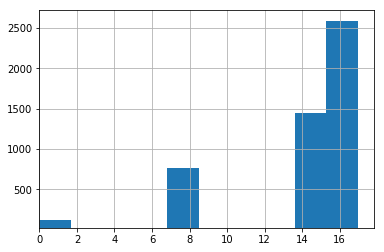

age_limite
0      123
7      765
14    1441
17    2590
dtype: int64

In [74]:
u = datas_raw.age_limite
u.hist()
plt.xlim(0)
plt.ylim(22)
plt.show()

datas_raw.groupby(['age_limite']).size()

# Répartition par Pays

In [75]:
sum(datas_raw.country.isnull())

5

In [76]:
datas_raw[datas_raw.country.isnull()][['movie_title', 'movie_imdb_link','country']]

,movie_title,movie_imdb_link,country
4,Star Wars: Episode VII - The Force Awakens ...,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN
279,"10,000 B.C.",http://www.imdb.com/title/tt1869849/?ref_=fn_t...,NaN
2370,"Gone, Baby, Gone",http://www.imdb.com/title/tt1697237/?ref_=fn_t...,NaN
3397,Preacher,http://www.imdb.com/title/tt5016504/?ref_=fn_t...,NaN
4021,Dawn Patrol,http://www.imdb.com/title/tt2073661/?ref_=fn_t...,NaN


> En allant sur Internet on voit que les 5 sont des USA
> 
> On modifie les données à la main

In [77]:
datas_raw.loc[[4,279,2370,3397, 4021],'country'] = 'USA'

In [78]:
datas_raw.country.unique()

array(['USA', 'UK', 'New Zealand', 'Canada', 'Australia', 'Belgium',
       'Japan', 'Germany', 'China', 'France', 'New Line', 'Mexico',
       'Spain', 'Hong Kong', 'Czech Republic', 'India', 'Soviet Union',
       'South Korea', 'Peru', 'Italy', 'Russia', 'Aruba', 'Denmark',
       'Libya', 'Ireland', 'South Africa', 'Iceland', 'Switzerland',
       'Romania', 'West Germany', 'Chile', 'Netherlands', 'Hungary',
       'Panama', 'Greece', 'Sweden', 'Norway', 'Taiwan', 'Official site',
       'Cambodia', 'Thailand', 'Slovakia', 'Bulgaria', 'Iran', 'Poland',
       'Georgia', 'Turkey', 'Nigeria', 'Brazil', 'Finland', 'Bahamas',
       'Argentina', 'Colombia', 'Israel', 'Egypt', 'Kyrgyzstan',
       'Indonesia', 'Pakistan', 'Slovenia', 'Afghanistan',
       'Dominican Republic', 'Cameroon', 'United Arab Emirates', 'Kenya',
       'Philippines'], dtype=object)

> 3 valeurs spéciales : 
> - 'Official site' : erreur à modifier en mettant USA (cf lien)
> - 'Soviet Union' : à remplacer par "Russia"
> - 'West Germany' : à remplacer par 'Germany'

In [79]:
datas_raw[datas_raw['country']=='Official site']

,id,movie_title,title_year,imdb_score,content_rating,duration,aspect_ratio,color,movie_imdb_link,budget,...,acteur_Fisher Stevens,acteur_Nia Long,acteur_Michael Jai White,acteur_Aidan Quinn,acteur_Lin Shaye,acteur_Paul Sorvino,acteur_Beverly D'Angelo,acteur_Hope Davis,acteur_Bruce Dern,age_limite
2675,1555064,Country Strong,2010.0,6.3,PG-13,117.0,2.35,Color,http://www.imdb.com/title/tt1555064/?ref_=fn_t...,15000000.0,...,False,False,False,False,False,False,False,False,False,14


In [80]:
datas_raw.loc[2675, 'country'] = 'USA'
datas_raw.loc[1061, 'country'] = 'Russia'

datas_raw.loc[[1815, 2970, 4335], 'country'] = 'Germany'

## Histogramme des répartitions

In [81]:
u = datas_raw.country.value_counts(normalize=True)

uu = u.groupby(
        np.where(u.values<0.005,'*** autres ***',u.index))\
        .agg(['sum'])\
        .rename(columns={'sum':'freq'},inplace=False)
uu.sort_values('freq',ascending=False,inplace=True)
uu

,freq
USA,0.755641
UK,0.088229
*** autres ***,0.049807
France,0.031307
Canada,0.025208
Germany,0.019719
Australia,0.010775
India,0.006912
Spain,0.006709
China,0.005692


<Figure size 900x600 with 0 Axes>

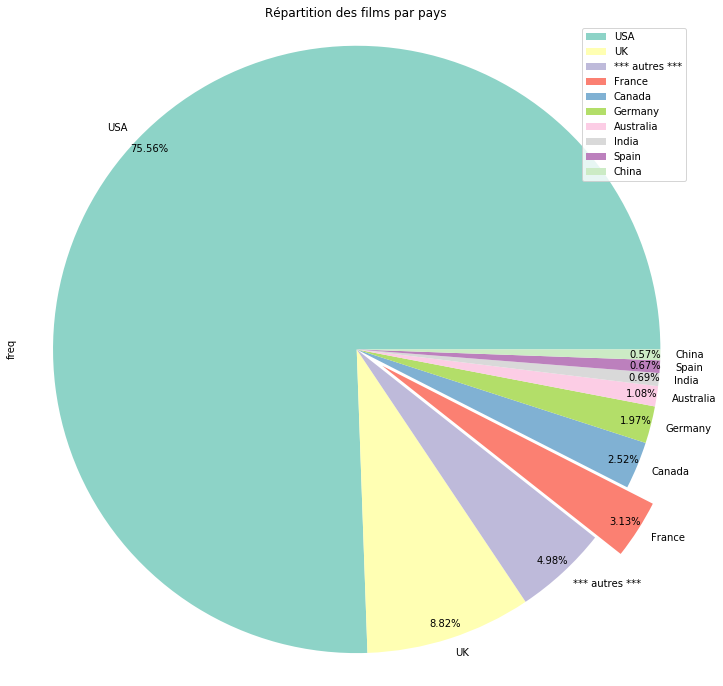

In [82]:
from matplotlib import cm

explode = tuple([0 if idx!='France' else 0.1 for idx in uu.index])

def change_label(values):
    res = [i for i in values]
    return res

cs=cm.Set3(np.arange(len(uu.index)+0.0)/(len(uu.index)+0.0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/1.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_autopct

fig = plt.figure(dpi=150)

uu.plot(kind='pie',x='index',y='freq',\
        explode=explode,\
        legend=True,\
        autopct=make_autopct(uu.freq),\
        #figsize=(12,12),\
        figsize=(12,12),\
        labels=change_label(uu.index),
        #startangle=90,
        colors=cs,
        #colors=colors2,
        #colormap=plt.cm.Set2,
        shadow  = False,
        frame   = False,
        labeldistance=1.05,
        pctdistance=0.95,
        #legendsdistance=1.05
       )

# 8 - On uniformise les proportions x / y
plt.title('Répartition des films par pays')
plt.axis('equal')
plt.savefig('Repartition_par_pays.png')
plt.show()

# Langues

In [83]:
datas_raw[(datas_raw.language.isnull())][['movie_title','country']]

,movie_title,country
4,Star Wars: Episode VII - The Force Awakens ...,USA
279,"10,000 B.C.",USA
2459,Unforgettable,USA
3086,September Dawn,USA
3539,Alpha and Omega 4: The Legend of the Saw Tooth...,USA
3869,Silent Movie,USA
4110,Love's Abiding Joy,USA
4409,Kickboxer: Vengeance,USA
4630,A Fine Step,USA
4810,Intolerance: Love's Struggle Throughout the Ages,USA


> Par facilité on va mettre la lanque anglaise

In [84]:
idx = datas_raw[(datas_raw.language.isnull())].index
datas_raw.loc[idx, 'language'] = 'English'

In [85]:
datas_raw.language.unique()

array(['English', 'Japanese', 'French', 'Mandarin', 'Aboriginal',
       'Spanish', 'Filipino', 'Hindi', 'Russian', 'Maya', 'Kazakh',
       'Telugu', 'Cantonese', 'Icelandic', 'German', 'Aramaic', 'Italian',
       'Dutch', 'Dari', 'Hebrew', 'Chinese', 'Mongolian', 'Swedish',
       'Korean', 'Thai', 'Polish', 'Bosnian', 'None', 'Hungarian',
       'Portuguese', 'Danish', 'Arabic', 'Norwegian', 'Czech', 'Kannada',
       'Zulu', 'Panjabi', 'Tamil', 'Dzongkha', 'Vietnamese', 'Indonesian',
       'Urdu', 'Romanian', 'Persian', 'Slovenian', 'Greek', 'Swahili'],
      dtype=object)

## Histogramme des répartitions

In [86]:
u = datas_raw.language.value_counts(normalize=True)

uu = u.groupby(
        np.where(u.values<0.005,'*** autres ***',u.index))\
        .agg(['sum'])\
        .rename(columns={'sum':'freq'},inplace=False)
uu.sort_values('freq',ascending=False,inplace=True)
uu

,freq
English,0.934336
*** autres ***,0.036999
French,0.014840
Spanish,0.008132
Hindi,0.005692


<Figure size 900x600 with 0 Axes>

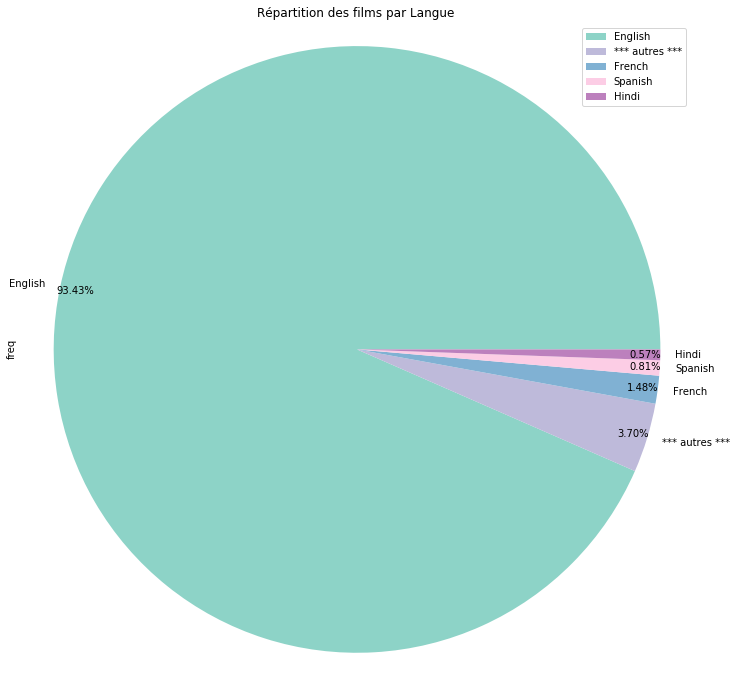

In [87]:
from matplotlib import cm

explode = tuple([0 if idx!='France' else 0.1 for idx in uu.index])

def change_label(values):
    res = [i for i in values]
    return res

cs=cm.Set3(np.arange(len(uu.index)+0.0)/(len(uu.index)+0.0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/1.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_autopct

fig = plt.figure(dpi=150)

uu.plot(kind='pie',x='index',y='freq',\
        explode=explode,\
        legend=True,\
        autopct=make_autopct(uu.freq),\
        #figsize=(12,12),\
        figsize=(12,12),\
        labels=change_label(uu.index),
        #startangle=90,
        colors=cs,
        #colors=colors2,
        #colormap=plt.cm.Set2,
        shadow  = False,
        frame   = False,
        labeldistance=1.05,
        pctdistance=0.95,
        #legendsdistance=1.05
       )

# 8 - On uniformise les proportions x / y
plt.title('Répartition des films par Langue')
plt.axis('equal')
plt.savefig('Repartition_par_langue.png')
plt.show()

In [88]:
nb_mots_clef_max = 1000
country = most_common_words(datas_raw['country'],nb_mot_affichage=100, return_values=True, affiche=False)
country = country.most_common(nb_mots_clef_max)
country = [i[0] for i in country]

# On ajoute les features de director_name
for name in country:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['country_'+name] = datas_raw['country'].apply(is_something, liste_mots=my_liste_mot)

In [89]:
nb_mots_clef_max = 1000
language = most_common_words(datas_raw['language'],nb_mot_affichage=100, return_values=True, affiche=False)
language = language.most_common(nb_mots_clef_max)
language = [i[0] for i in language]

# On ajoute les features de director_name
for name in language:
    my_liste_mot = []
    my_liste_mot.append(name)
    datas_raw['language_'+name] = datas_raw['language'].apply(is_something, liste_mots=my_liste_mot)

## Noir & Blanc 
> Répartition avec grande majorité de Couleur 
>
> Il manque 19 films non renseignés
> 
> Après analyse (il n'y a que 19 films), nous pouvons mettre à Couleurs
> les valeurs manquantes
> On en profite pour retirer l'espace dans la valeur " Black and White"

In [90]:
datas_raw.loc[datas_raw.color.isnull(),'color'] = 'Color'
datas_raw.loc[datas_raw['color']==' Black and White','color'] = 'Black and White'

In [91]:
# On analyse la répartition Noir & Blanc / Couleur 
u = datas_raw[datas_raw.color.notnull()]
datas_raw.groupby(['color']).size()

color
Black and White     204
Color              4715
dtype: int64

In [92]:
datas_raw['black_and_white'] = datas_raw['color'].apply(is_something, liste_mots=['Black and White'])

# Répartition des score imdb

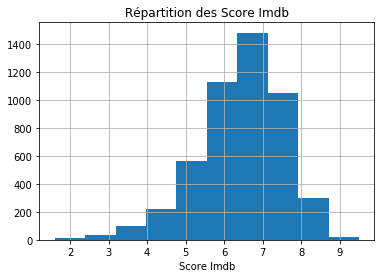

In [93]:
u = datas_raw['imdb_score']

plt.xlabel('Score Imdb')
plt.title('Répartition des Score Imdb')
u.hist()
plt.show()

## Répartition par années

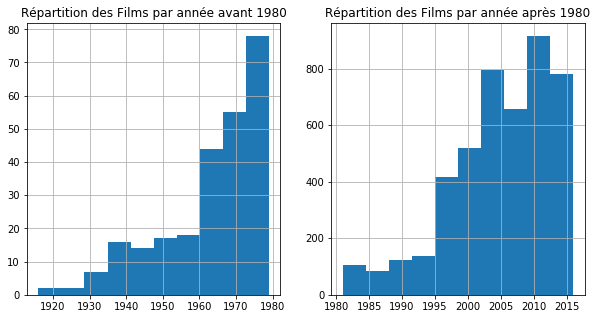

In [94]:
# Après 1980 
u1 = datas_raw[datas_raw['title_year']<1980]['title_year']
u2 = datas_raw[datas_raw['title_year']>1980]['title_year']



#fig = plt.figure(figsize=(10,5), dpi = 150 )
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Répartition des Films par année avant 1980")
u1.hist()

plt.subplot(1,2,2)
plt.title("Répartition des Films par année après 1980")
u2.hist()

plt.show()

# Ajout de l'audience 
> Donne l'information sur les revenus du films (donc l'audience)

In [95]:
def audience():
    u1 = datas_raw['gross']
    desc = u1.describe()
    q1 = desc.get('25%')    
    q2 = desc.get('50%')
    q3 = desc.get('75%')
    res_audience = []
    for i in u1:
        if np.isnan(i):
            res_audience.append(i)
            continue
        if i<q1:
            res_audience.append('intime')
        elif i<q2:
            res_audience.append('moyen-')
        elif i<q3:
            res_audience.append('moyen+')
        else:
            res_audience.append('populaire')
    datas_raw['audience']=pd.Series(res_audience)

audience()

# Sauvegarde du fichier nettoyé

In [96]:
datas_raw.to_csv('movie_metadata_nettoye_1.csv', index=False)

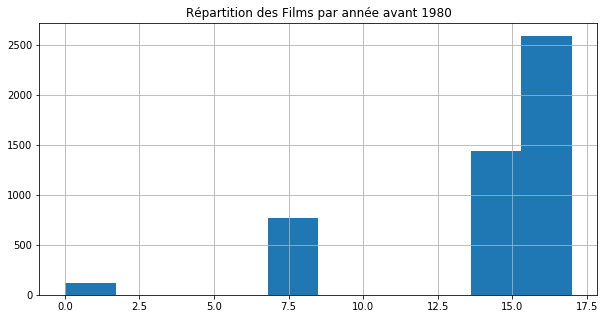

In [97]:
u1 = datas_raw['age_limite']

fig = plt.figure(figsize=(10,5))

#plt.subplot(1,2,1)
plt.title("Répartition des Films par année avant 1980")
u1.hist()
plt.show()